## Modules

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import metrics

## Preprocessing

In [2]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("../Data/Data_te_std.pkl")   #Standardized Dataset
Attack_label = pd.read_pickle("../Data/Attack_label.pkl") #Attack Labels 0:Normal, 1:Attack
Attack_type_raw = pd.read_pickle("../Data/Attack_type.pkl")   #Attack Types 
mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
Attack_type = Attack_type_raw.map(mapping_dict)

# Joining Dataset_std and Attack_type
Dataset_std['Attack_type'] = Attack_type

#Oversampling the minority classes
Dataset, Target_label = SMOTEENN(random_state= 22).fit_resample(Dataset_std, Attack_label)
Target_type = Dataset['Attack_type']
Dataset = Dataset.drop(columns = 'Attack_type')

#Splitting the dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(Dataset, Target_label, train_size=30000, test_size=30000, random_state=22) # stratify= Target_type / Target_label
_, _, Y_ref, _ = train_test_split(Dataset, Target_type, train_size=30000 ,test_size=30000, random_state=22)

## Training and Testing Dataset for PCA
pca = PCA(n_components=15)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)


## Functions

In [25]:
#Function to get the indices of the attack type
def get_index(attack_type: int, data: np.ndarray) -> np.ndarray:
    indices = np.where(data[:] == attack_type)[0]
    return indices  

#Function to remove a attack type from the dataframe
def remove_attack_type(data_X: np.ndarray, attack_type: int) -> np.ndarray:
    indices_to_remove = get_index(attack_type, Y_ref)
    new_data = np.delete(data_X, indices_to_remove, axis=0)
    return new_data

#Function for Evaluation
def evaluate_bin(test: np.ndarray, pred: np.ndarray, display:bool = True) -> None:
    tn, fp, fn, tp = metrics.confusion_matrix(test, pred, labels=[0,1]).ravel()
    df_metric = pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test, pred)*100,                              
                              'Precision':metrics.precision_score(test, pred, pos_label= 1, average = 'binary')*100,
                              'Recall': metrics.recall_score(test, pred, pos_label= 1, average = 'binary')*100,
                              'F1-Score': metrics.f1_score(test, pred, pos_label= 1, average = 'binary' )*100,
                              'FPR':(fp/(tn+fp))*100}, 
                              index= ['Anomaly'])
    if display:
        metrics.ConfusionMatrixDisplay.from_predictions(test, pred, display_labels=['Normal', 'Anomaly']) #normalize= 'true'
    return df_metric

#Function for looping training and testing
def train_and_eval(model, x, y, pca:bool = False) -> pd.DataFrame:
    if pca:
        y_pred= model.fit(X_train_PCA, y).predict(X_test_PCA)
        return evaluate_bin(Y_test, y_pred, display=False)
    else:
        y_pred = model.fit(x, y).predict(X_test)
        return evaluate_bin(Y_test, y_pred, display=False)

#Classes for pipeline
class SampleExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, num_samples=1000):
        self.num_samples = num_samples
        self.is_fitting = False
    
    def fit(self, X, y=None):
        self.is_fitting = True
        return self
    
    def transform(self, X, y=None):
        if self.is_fitting:
            X_sampled = X[:self.num_samples]
            if y is not None:
                y_sampled = y[:self.num_samples]
                return X_sampled , y_sampled
            else:
                return X_sampled
        else:
            return X
        
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)
    
# Custom pipeline to handle different behavior during fit and predict
class CustomPipeline(Pipeline):
    def fit(self, X, y=None, **fit_params):
        Xt, yt = self._fit_transform(X, y, **fit_params)
        self.steps[-1][-1].fit(Xt, yt, **fit_params)
        return self

    def _fit_transform(self, X, y=None, **fit_params):
        for name, transform in self.steps[:-1]:
            if transform is not None:
                X, y = transform.fit_transform(X, y)
        return X, y

    def predict(self, X, **predict_params):
        for name, transform in self.steps[:-1]:
            if transform is not None:
                transform.is_fitting = False  
                X = transform.transform(X)
        return self.steps[-1][-1].predict(X, **predict_params)


## Models

In [16]:
#Modal definition
svc = SVC(kernel='rbf', C=500, probability=True)
rf = RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 0.8, max_samples= 0.8, n_estimators= 80, random_state=22)
knn = KNeighborsClassifier(leaf_size= 5, n_neighbors= 8, p= 1, weights= 'distance')
lof = LocalOutlierFactor(n_neighbors=6, novelty=True, metric= 'euclidean', leaf_size=20)
vote_clf = VotingClassifier(estimators=[('svc', svc), ('knn', knn), ('rf', rf)], voting='soft') 

models = {'SVC': CustomPipeline([('sample_extractor', SampleExtractor(num_samples=1000)), ('svc', svc)]),
          'KNN':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=30000)), ('knn', knn)]),
          'Random Forest':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=10000)), ('rf', rf)]),
          'Voting Ensemble':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=10000)), ('vote_clf', vote_clf)])
          }

## All Binary Modals

In [27]:
# Binary Classifiers
clf_results = pd.DataFrame()
clf_results_pca = pd.DataFrame()

for model_name, model in models.items(): 
    clf_results = pd.concat([clf_results, train_and_eval(model, X_train, Y_train)], axis=0, ignore_index=True)
    clf_results_pca = pd.concat([clf_results_pca, train_and_eval(model, X_train_PCA, Y_train, True)], axis=0, ignore_index=True)

#LOF training and testing
Dataset_norm = pd.read_pickle("../Data/Data_te_norm.pkl")
Dataset_norm, Target_label_norm = SMOTEENN(random_state= 22).fit_resample(Dataset_norm, Attack_label)
norm_X_train, norm_X_test, norm_Y_train, norm_Y_test = train_test_split(Dataset, Target_label, train_size=50000, test_size=30000, random_state=22)
train_x = norm_X_train[norm_Y_train == 0]
test_Y = (((norm_Y_test*2)-1)*-1) #Converting the labels to -1 and 1
pred = lof.fit(train_x).predict(norm_X_test)
tn, fp, fn, tp = metrics.confusion_matrix(test_Y, pred, labels=[1,-1]).ravel()
clf_results = pd.concat([clf_results, pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test_Y, pred)*100,                              
                              'Precision':metrics.precision_score(test_Y, pred, pos_label= -1, average = 'binary')*100,
                              'Recall': metrics.recall_score(test_Y, pred, pos_label= -1, average = 'binary')*100,
                              'F1-Score': metrics.f1_score(test_Y, pred, pos_label= -1, average = 'binary' )*100,
                              'FPR':(fp/(tn+fp))*100},
                              index= ['LOF'])], axis=0, ignore_index=True)


train_x_PCA = pca.fit_transform(train_x)
test_x_PCA = pca.transform(norm_X_test)
pred_PCA = lof.fit(train_x_PCA).predict(test_x_PCA)
tn, fp, fn, tp = metrics.confusion_matrix(test_Y, pred_PCA, labels=[1,-1]).ravel()
clf_results_pca = pd.concat([clf_results_pca, pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test_Y, pred_PCA)*100,                              
                              'Precision':metrics.precision_score(test_Y, pred_PCA, pos_label= -1, average = 'binary')*100,
                              'Recall': metrics.recall_score(test_Y, pred_PCA, pos_label= -1, average = 'binary')*100,
                              'F1-Score': metrics.f1_score(test_Y, pred_PCA, pos_label= -1, average = 'binary' )*100,
                              'FPR':(fp/(tn+fp))*100},
                              index= ['LOF'])], axis=0, ignore_index=True)

clf_results.index = pd.MultiIndex.from_product([['SVC', 'KNN', 'Random Forest', 'Voting Ensemble', 'LOF']] ,names=['Model'])
clf_results_pca.index = pd.MultiIndex.from_product([['SVC', 'KNN', 'Random Forest', 'Voting Ensemble', 'LOF']] ,names=['Model after PCA'])
print(clf_results)
print(clf_results_pca)

                 Average Accuracy Score  Precision     Recall   F1-Score  \
Model                                                                      
SVC                           81.086667  89.497445  70.290340  78.739508   
KNN                           84.823333  88.214102  80.264918  84.051981   
Random Forest                 96.030000  95.689140  96.374097  96.030397   
Voting Ensemble               92.306667  95.467626  88.774418  91.999445   
LOF                           78.046667  90.411753  62.576933  73.962204   

                       FPR  
Model                       
SVC               8.191602  
KNN              10.649748  
Random Forest     4.311719  
Voting Ensemble   4.185490  
LOF               6.590486  
                 Average Accuracy Score  Precision     Recall   F1-Score  \
Model after PCA                                                            
SVC                           80.973333  88.525684  71.019534  78.812175   
KNN                           84.613

## Novel Attack Tests

In [20]:
#Training set without the novel attack types
X_train_nov1 = remove_attack_type(np.array(X_train), 1)
Y_train_nov1 = remove_attack_type(np.array(Y_train), 1)
X_train_nov2 = remove_attack_type(np.array(X_train), 2)
Y_train_nov2 = remove_attack_type(np.array(Y_train), 2)
X_train_nov3 = remove_attack_type(np.array(X_train), 3)
Y_train_nov3 = remove_attack_type(np.array(Y_train), 3)
X_train_nov4 = remove_attack_type(np.array(X_train), 4)
Y_train_nov4 = remove_attack_type(np.array(Y_train), 4)
X_train_nov5 = remove_attack_type(np.array(X_train), 5)
Y_train_nov5 = remove_attack_type(np.array(Y_train), 5)

trainings = [(X_train_nov1, Y_train_nov1), (X_train_nov2, Y_train_nov2), (X_train_nov3, Y_train_nov3),
             (X_train_nov4, Y_train_nov4), (X_train_nov5, Y_train_nov5)]

model_results = pd.DataFrame()
for model_name, model in models.items(): 
    result = pd.DataFrame()
    for i, (x, y) in enumerate(trainings):
        result = pd.concat([result, train_and_eval(model, x, y)], axis=0, ignore_index=True)
    model_results = pd.concat([model_results, result], axis=0)
    
model_results.index = pd.MultiIndex.from_product([models.keys(), ['novel type 1', 'novel type 2', 'novel type 3', 'novel type 4', 'novel type 5']],
                                                 names=['Model', 'Novel Type'])

model_results

Average Accuracy Score  Precision     Recall  \
Model           Novel Type                                                   
SVC             novel type 1               80.340000  90.358544  67.774953   
                novel type 2               81.133333  89.780709  70.116404   
                novel type 3               81.046667  89.500171  70.196682   
                novel type 4               80.126667  97.889576  61.439657   
                novel type 5               81.143333  90.717854  69.240032   
KNN             novel type 1               84.260000  89.427822  77.582285   
                novel type 2               84.770000  88.546386  79.749799   
                novel type 3               84.793333  88.217545  80.191330   
                novel type 4               84.286667  93.794933  73.314156   
                novel type 5               82.183333  91.719524  70.618143   
Random Forest   novel type 1               90.503333  95.529465  84.914370   
                novel type 2               93.163333  95.537038  90.507091   
                novel type 3               95.873333  95.675640  96.059674   
                novel type 4               94.910000  97.528154  92.119347   
                novel type 5               92.803333  96.495310  88.781108   
Voting Ensemble novel type 1               91.423333  97.983715  84.526358   
                novel type 2               91.993333  95.694930  87.884667   
                novel type 3               92.310000  95.592585  88.654001   
                novel type 4               87.200000  98.362940  75.568638   
                novel type 5               86.663333  97.682725  75.013380   

                               F1-Score        FPR  
Model           Novel Type                          
SVC             novel type 1  77.454128   7.181770  
                novel type 2  78.739388   7.925857  
                novel type 3  78.681764   8.178315  
                novel type 4  75.495273   1.315440  
                novel type 5  78.537011   7.035610  
KNN             novel type 1  83.084969   9.108424  
                novel type 2  83.918201  10.244486  
                novel type 3  84.013176  10.636460  
                novel type 4  82.299489   4.816636  
                novel type 5  79.797407   6.331385  
Random Forest   novel type 1  89.909687   3.946319  
                novel type 2  92.954069   4.198778  
                novel type 3  95.867272   4.311719  
                novel type 4  94.746620   2.318629  
                novel type 5  92.477614   3.202232  
Voting Ensemble novel type 1  90.758898   1.727345  
                novel type 2  91.623657   3.926389  
                novel type 3  91.992642   4.059261  
                novel type 4  85.472155   1.249003  
                novel type 5  84.860181   1.767207

## Binary Classifier with 5 class SMOTEENN

In [29]:
#Training set without the novel attack types
X_train_nov1 = remove_attack_type(np.array(X_train), 1)
Y_train_nov1 = remove_attack_type(np.array(Y_train), 1)
X_train_nov2 = remove_attack_type(np.array(X_train), 2)
Y_train_nov2 = remove_attack_type(np.array(Y_train), 2)
X_train_nov3 = remove_attack_type(np.array(X_train), 3)
Y_train_nov3 = remove_attack_type(np.array(Y_train), 3)
X_train_nov4 = remove_attack_type(np.array(X_train), 4)
Y_train_nov4 = remove_attack_type(np.array(Y_train), 4)
X_train_nov5 = remove_attack_type(np.array(X_train), 5)
Y_train_nov5 = remove_attack_type(np.array(Y_train), 5)

trainings = [(X_train_nov1, Y_train_nov1), (X_train_nov2, Y_train_nov2), (X_train_nov3, Y_train_nov3),
             (X_train_nov4, Y_train_nov4), (X_train_nov5, Y_train_nov5)]


model_results = pd.DataFrame()
for model_name, model in models.items(): 
    result = pd.DataFrame()
    for i, (x, y) in enumerate(trainings):
        result = pd.concat([result, train_and_eval(model, x, y)], axis=0, ignore_index=True)
    model_results = pd.concat([model_results, result], axis=0)
    
model_results.index = pd.MultiIndex.from_product([models.keys(), ['novel type 1', 'novel type 2', 'novel type 3', 'novel type 4', 'novel type 5']],
                                                 names=['Model', 'Novel Type'])

model_results


Average Accuracy Score  Precision     Recall  \
Model           Novel Type                                                   
SVC             novel type 1               87.692528  80.360630  99.603210   
                novel type 2               87.758657  80.446905  99.603210   
                novel type 3               84.279461  80.177862  90.864903   
                novel type 4               87.973825  81.575295  97.949588   
                novel type 5               90.564222  89.869686  91.328155   
KNN             novel type 1               93.695992  89.400897  99.074487   
                novel type 2               93.847498  89.446846  99.355216   
                novel type 3               93.886484  89.509290  99.356208   
                novel type 4               95.904912  95.587641  96.209664   
                novel type 5               93.244437  90.629022  96.387227   
Random Forest   novel type 1               94.377026  97.367166  91.162495   
                novel type 2               98.594503  97.639449  99.582379   
                novel type 3               98.612269  97.645835  99.612138   
                novel type 4               99.242473  99.561666  98.912795   
                novel type 5               94.626739  97.454219  91.592021   
Voting Ensemble novel type 1               90.841571  84.485925  99.943457   
                novel type 2               90.907700  84.567616  99.966273   
                novel type 3               91.159387  84.950543  99.933538   
                novel type 4               95.152813  92.989369  97.616284   
                novel type 5               91.506319  86.064089  98.949499   

                               F1-Score  
Model           Novel Type               
SVC             novel type 1  88.953166  
                novel type 2  89.005997  
                novel type 3  85.187510  
                novel type 4  89.015700  
                novel type 5  90.593051  
KNN             novel type 1  93.989441  
                novel type 2  94.141034  
                novel type 3  94.176054  
                novel type 4  95.897644  
                novel type 5  93.419478  
Random Forest   novel type 1  94.162730  
                novel type 2  98.601344  
                novel type 3  98.619186  
                novel type 4  99.236170  
                novel type 5  94.432228  
Voting Ensemble novel type 1  91.566922  
                novel type 2  91.624465  
                novel type 3  91.834930  
                novel type 4  95.246668  
                novel type 5  92.058087

<Axes: title={'center': 'F1-Score of Models on Novel Attack Types'}, xlabel='Model'>

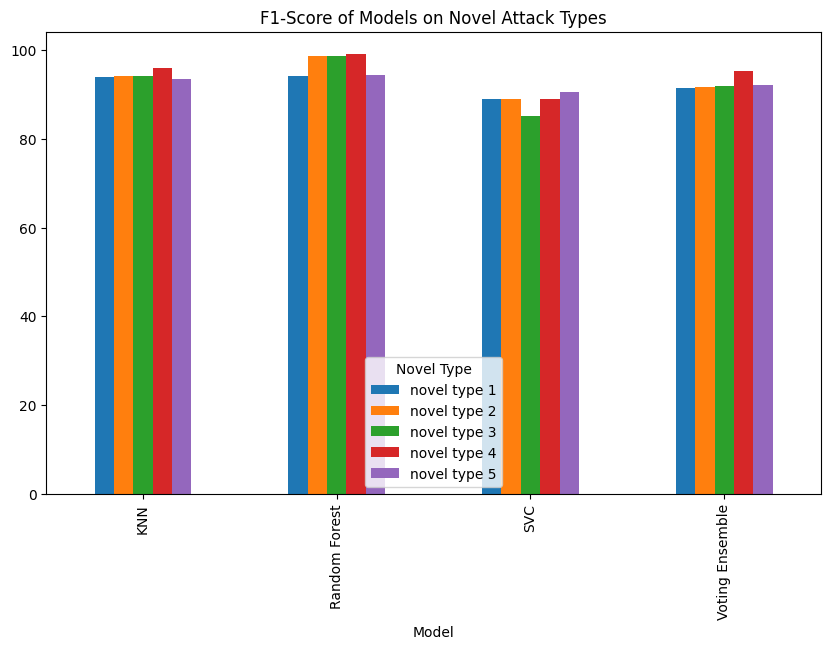

In [30]:
model_results['F1-Score'].unstack().plot(kind='bar', figsize=(10, 6), title='F1-Score of Models on Novel Attack Types')